# install torch

In [1]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0d/4a/e51420d46cfc90562e85af2fee912237c662ab31140ab179e49bd69401d6/torch-2.5.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/203.1 MB 6.1 MB/s eta 0:00:34
   ---------------------------------------- 0.6/203.1 MB 6.3 MB/s eta 0:00:33
   ---------------------------------------- 1.0/203.1 MB 6.8 MB/s eta 0:00:30
   ---------------------------------------- 1.4/203.1 MB 7.5 MB/s eta 0:00:27
   ---------------------------------------- 1.8/203.1 MB 8.0 MB/s eta 0:00:26
   ---------------------------------------- 2.4/203.1 MB 8.5 MB/s eta 0:00:24
    --------------------------------------- 2.9/203.1

In [2]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/69/55/ce836703ff77bb21582c3098d5311f8ddde7eadc7eab04be9561961f4725/torchvision-0.20.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.6 MB 991.0 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.6 MB 2.5 MB/s eta 0:00:01
   -------- ------------------------------- 0.3/1.6 MB 2.8 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.6 MB 4.0 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.6 MB 3.6 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.6 MB 3.8 MB/s eta 0:00:01
   ------------------------------ --------- 1.2/1.6 MB 3.9 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 3.8 MB/s eta 0:00:01
   --------------------------------

In [5]:
!pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

cpu


# load data

In [2]:

# Dataset and Dataloader setup
transform = transforms.ToTensor()
kmnst_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_idx, test_idx = train_test_split(range(len(kmnst_dataset)), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 20% of total for validation

train_dataset = Subset(kmnst_dataset, train_idx)
val_dataset = Subset(kmnst_dataset, val_idx)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Autoencder 

In [3]:
# Encoder definition (no changes)
class Encoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(Encoder, self).__init__()
        self.encode_dim = bottleneck_size
        self.fc1 = nn.Linear(784, 800)
        self.bn1 = nn.BatchNorm1d(800)
        # self.fc2 = nn.Linear(800, 400)
        # self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(800, 200)
        self.bn3 = nn.BatchNorm1d(200)
        # self.fc4 = nn.Linear(200, 100)
        # self.bn4 = nn.BatchNorm1d(100)
        self.fc5 = nn.Linear(200, bottleneck_size)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = F.relu(self.bn1(self.fc1(x)))
        # x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        # x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x
        
# Decoder definition
class Decoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(bottleneck_size, 200)
        self.bn1 = nn.BatchNorm1d(200)
        # self.fc2 = nn.Linear(100, 200)
        # self.bn2 = nn.BatchNorm1d(200)
        # self.fc3 = nn.Linear(200, 400)
        # self.bn3 = nn.BatchNorm1d(400)
        self.fc4 = nn.Linear(200, 800)
        self.bn4 = nn.BatchNorm1d(800)
        self.fc5 = nn.Linear(800, 784)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        # x = F.relu(self.bn2(self.fc2(x)))
        # x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = torch.sigmoid(self.fc5(x))  # Normalize output to [0, 1]
        return x

# Training function for one epoch
def train_epoch(encoder, decoder, device, train_loader, criterion, optimizer):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        bottleneck = encoder(images)
        output = decoder(bottleneck)
        loss = criterion(output, images.view(images.size(0), -1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

# Validation function for one epoch
def val_epoch(encoder, decoder, device, val_loader, criterion):
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            bottleneck = encoder(images)
            output = decoder(bottleneck)
            loss = criterion(output, images.view(images.size(0), -1))
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Autoencoder training function
def ae_training(encoder, decoder, train_loader, val_loader, device, epochs, optimizer, criterion, patience=5):
    encoder.to(device)
    decoder.to(device)
    train_losses, val_losses = [], []
    
    best_val_loss = float('inf')
    best_encoder_weights = None
    best_decoder_weights = None
    patience_counter = 0

    print("Starting Training...")
    for epoch in range(epochs):
        start_time = time.time()

        # Training
        train_loss = train_epoch(encoder, decoder, device, train_loader, criterion, optimizer)
        train_losses.append(train_loss)

        # Validation
        val_loss = None
        if val_loader:
            val_loss = val_epoch(encoder, decoder, device, val_loader, criterion)
            val_losses.append(val_loss)

            # Check for improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_encoder_weights = encoder.state_dict()
                best_decoder_weights = decoder.state_dict()
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1

            # Early stopping condition
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        end_time = time.time()
        print(f"Epoch {epoch+1}/{epochs} | Time: {end_time - start_time:.2f}s")
        print(f"Train Loss: {train_loss:.6f}" + (f" | Val Loss: {val_loss:.6f}" if val_loader else ""))

    # Load best weights
    if best_encoder_weights and best_decoder_weights:
        encoder.load_state_dict(best_encoder_weights)
        decoder.load_state_dict(best_decoder_weights)
        print("Restored best model weights.")

    return train_losses, val_losses if val_loader else train_losses

def huber_loss(predicted, target, delta=1.0):
    """
    Custom Huber Loss function
    
    Args:
        predicted: Reconstructed input tensor
        target: Original input tensor
        delta: Hyperparameter controlling transition point
    """
    diff = torch.abs(predicted - target)
    quadratic = torch.minimum(diff, torch.tensor(delta))
    linear = diff - quadratic
    return torch.mean(0.5 * quadratic**2 + delta * linear)

In [4]:

# Model, criterion, and optimizer initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bottleneck_sizes = [45]
learning_rates = [0.0001, 0.0005, 0.001, 0.0015, 0.01]
train_losses = {}
valid_losses = {}

for bottleneck_size in bottleneck_sizes:
    train_losses[f"{bottleneck_size}"] = {}
    valid_losses[f"{bottleneck_size}"] = {}
    for learning_rate in learning_rates:
        encoder = Encoder(bottleneck_size)
        decoder = Decoder(bottleneck_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
        
        # Training
        print(f"bottleneck size : {bottleneck_size} and learning rate: {learning_rate}")
        train_losse, val_losse = ae_training(
            encoder, decoder, train_loader, val_loader, device, epochs=10, optimizer=optimizer, criterion=criterion)
        train_losses[f"{bottleneck_size}"][f"{learning_rate}"] = train_losse
        valid_losses[f"{bottleneck_size}"][f"{learning_rate}"] = val_losse

bottleneck size : 45 and learning rate: 0.0001
Starting Training...
Epoch 1/10 | Time: 32.75s
Train Loss: 0.091008 | Val Loss: 0.065233
Epoch 2/10 | Time: 32.39s
Train Loss: 0.058221 | Val Loss: 0.051375
Epoch 3/10 | Time: 32.65s
Train Loss: 0.047561 | Val Loss: 0.043196
Epoch 4/10 | Time: 30.13s
Train Loss: 0.040885 | Val Loss: 0.037886
Epoch 5/10 | Time: 32.85s
Train Loss: 0.036358 | Val Loss: 0.034104
Epoch 6/10 | Time: 32.37s
Train Loss: 0.033144 | Val Loss: 0.031561
Epoch 7/10 | Time: 32.72s
Train Loss: 0.030774 | Val Loss: 0.029604
Epoch 8/10 | Time: 32.35s
Train Loss: 0.029019 | Val Loss: 0.028065
Epoch 9/10 | Time: 32.20s
Train Loss: 0.027594 | Val Loss: 0.026923
Epoch 10/10 | Time: 32.65s
Train Loss: 0.026394 | Val Loss: 0.025922
Restored best model weights.
bottleneck size : 45 and learning rate: 0.0005
Starting Training...
Epoch 1/10 | Time: 32.54s
Train Loss: 0.058322 | Val Loss: 0.037626
Epoch 2/10 | Time: 32.22s
Train Loss: 0.033372 | Val Loss: 0.029271
Epoch 3/10 | Time:

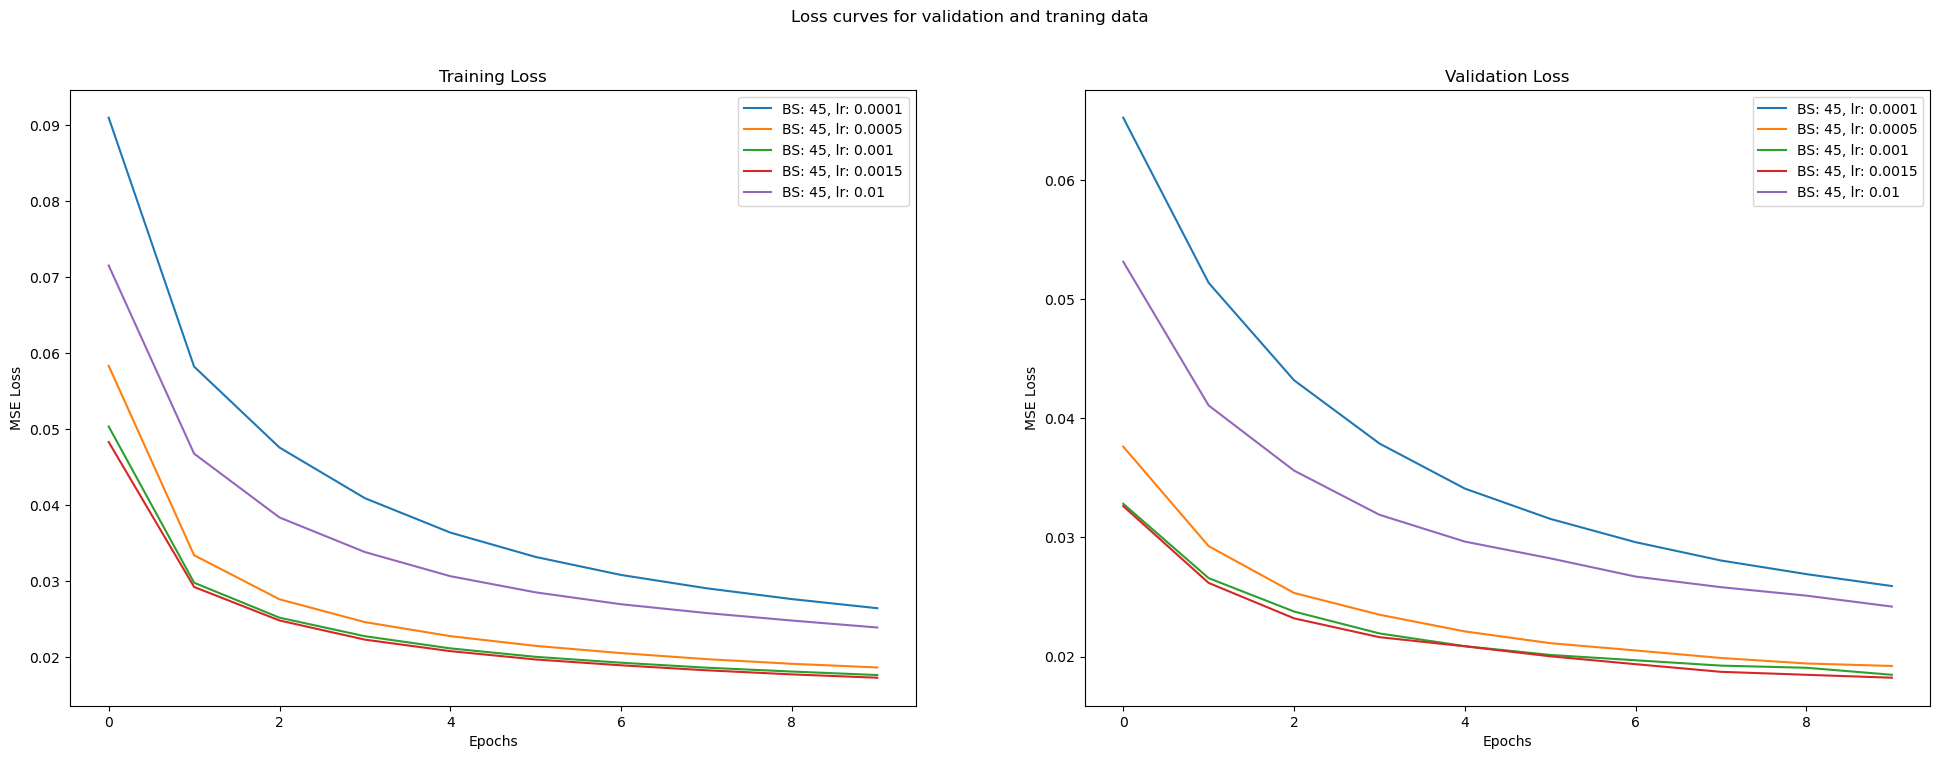

In [5]:
fig,ax = plt.subplots(ncols=2, nrows =1, figsize=(24,8))
fig.suptitle("Loss curves for validation and traning data")
for bottleneck_size in bottleneck_sizes:
    for learning_rate in learning_rates:
        ax[0].plot(train_losses[f"{bottleneck_size}"][f"{learning_rate}"], label = f"BS: {bottleneck_size}, lr: {learning_rate}")
        ax[1].plot(valid_losses[f"{bottleneck_size}"][f"{learning_rate}"], label = f"BS: {bottleneck_size}, lr: {learning_rate}")
        ax[0].set_xlabel("Epochs")
        ax[1].set_xlabel("Epochs")
        ax[0].set_ylabel("MSE Loss")
        ax[1].set_ylabel("MSE Loss")
ax[0].set_title("Training Loss")
ax[1].set_title("Validation Loss")
ax[0].legend()
ax[1].legend()
plt.show()

In [7]:

# Model, criterion, and optimizer initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bottleneck_sizes = [15, 45, 60, 75, 90]
learning_rates = [0.0015]


for bottleneck_size in bottleneck_sizes:
    train_losses[f"{bottleneck_size}"] = {}
    valid_losses[f"{bottleneck_size}"] = {}
    for learning_rate in learning_rates:
        encoder = Encoder(bottleneck_size)
        decoder = Decoder(bottleneck_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
        
        # Training
        print(f"bottleneck size : {bottleneck_size} and learning rate: {learning_rate}")
        train_losse, val_losse = ae_training(
            encoder, decoder, train_loader, val_loader, device, epochs=15, optimizer=optimizer, criterion=criterion)
        train_losses[f"{bottleneck_size}"][f"{learning_rate}"] = train_losse
        valid_losses[f"{bottleneck_size}"][f"{learning_rate}"] = val_losse

bottleneck size : 15 and learning rate: 0.0015
Starting Training...
Epoch 1/15 | Time: 31.68s
Train Loss: 0.056216 | Val Loss: 0.044767
Epoch 2/15 | Time: 32.15s
Train Loss: 0.043167 | Val Loss: 0.040944
Epoch 3/15 | Time: 31.77s
Train Loss: 0.040408 | Val Loss: 0.038960
Epoch 4/15 | Time: 31.57s
Train Loss: 0.038768 | Val Loss: 0.037715
Epoch 5/15 | Time: 32.00s
Train Loss: 0.037524 | Val Loss: 0.036872
Epoch 6/15 | Time: 32.72s
Train Loss: 0.036546 | Val Loss: 0.036310
Epoch 7/15 | Time: 32.37s
Train Loss: 0.035730 | Val Loss: 0.035890
Epoch 8/15 | Time: 31.42s
Train Loss: 0.035035 | Val Loss: 0.035684
Epoch 9/15 | Time: 31.70s
Train Loss: 0.034565 | Val Loss: 0.035004
Epoch 10/15 | Time: 31.74s
Train Loss: 0.033965 | Val Loss: 0.034691
Epoch 11/15 | Time: 31.78s
Train Loss: 0.033597 | Val Loss: 0.034657
Epoch 12/15 | Time: 31.88s
Train Loss: 0.033152 | Val Loss: 0.034428
Epoch 13/15 | Time: 31.92s
Train Loss: 0.032715 | Val Loss: 0.034105
Epoch 14/15 | Time: 32.47s
Train Loss: 0.032

In [11]:
# train_losses

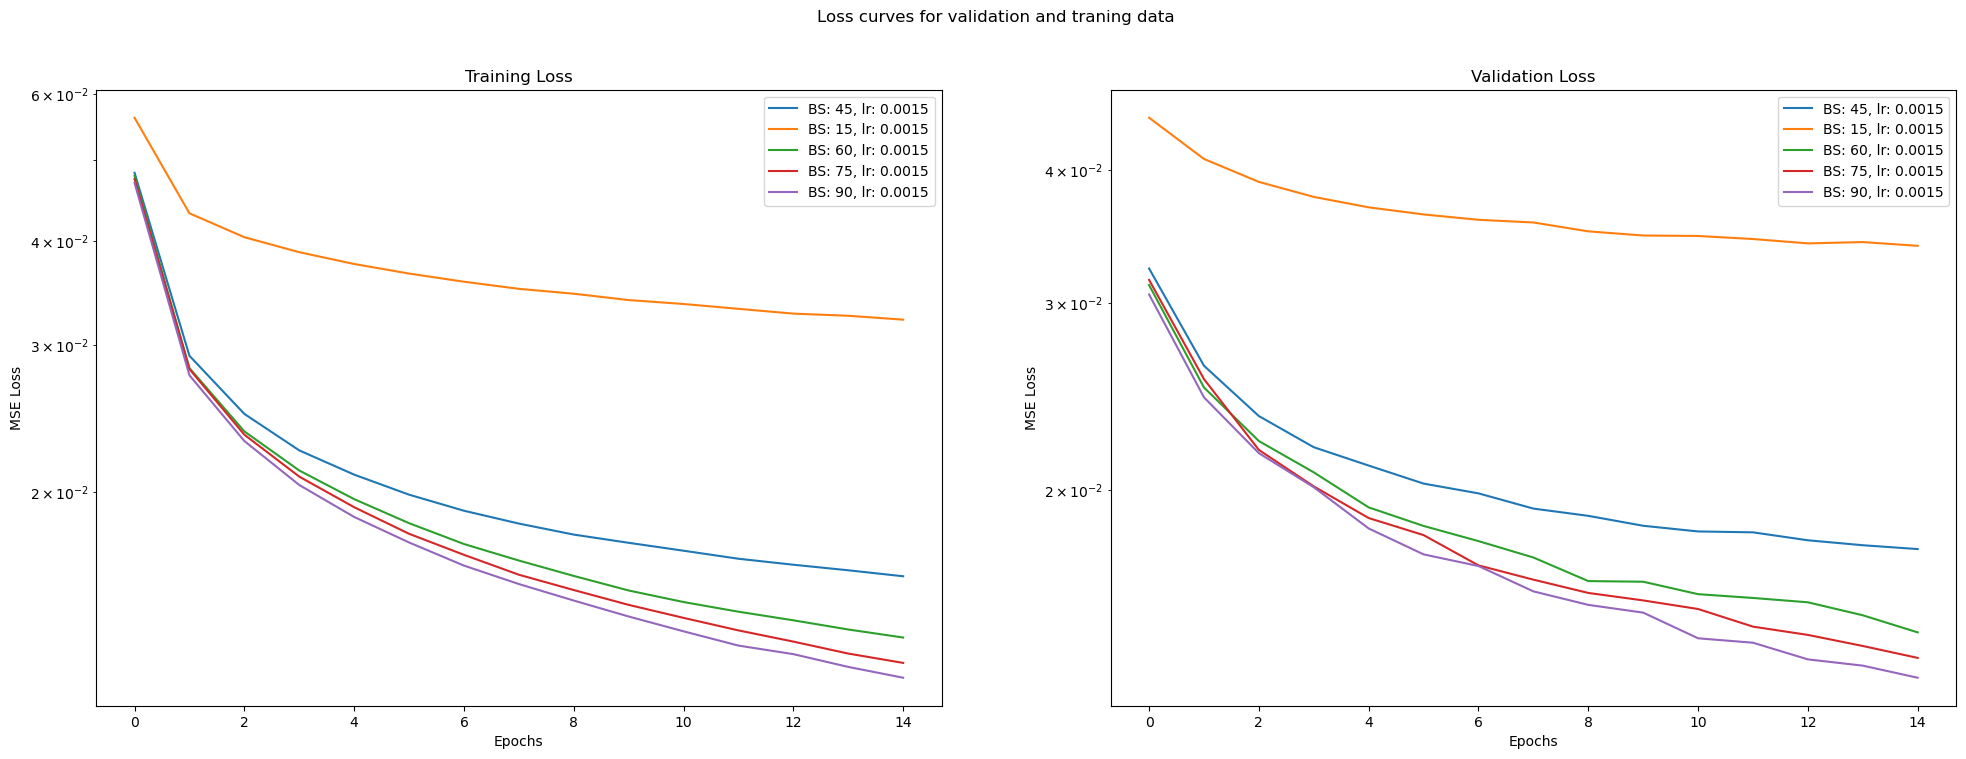

In [8]:
fig,ax = plt.subplots(ncols=2, nrows =1, figsize=(24,8))
fig.suptitle("Loss curves for validation and traning data")
for bottleneck_size in train_losses:
    for learning_rate in train_losses[bottleneck_size]:
        if learning_rate == '0.0015':
            ax[0].plot(train_losses[bottleneck_size][learning_rate], label = f"BS: {bottleneck_size}, lr: {learning_rate}")
            ax[1].plot(valid_losses[bottleneck_size][learning_rate], label = f"BS: {bottleneck_size}, lr: {learning_rate}")
        ax[0].set_xlabel("Epochs")
        ax[1].set_xlabel("Epochs")
        ax[0].set_ylabel("MSE Loss")
        ax[1].set_ylabel("MSE Loss")
ax[0].set_title("Training Loss")
ax[1].set_title("Validation Loss")
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].legend()
ax[1].legend()
plt.show()

Starting Training...
Epoch 1/50 | Time: 42.50s
Train Loss: 0.022449 | Val Loss: 0.015502
Epoch 2/50 | Time: 39.52s
Train Loss: 0.014527 | Val Loss: 0.012804
Epoch 3/50 | Time: 40.52s
Train Loss: 0.012598 | Val Loss: 0.011572
Epoch 4/50 | Time: 41.35s
Train Loss: 0.011499 | Val Loss: 0.010721
Epoch 5/50 | Time: 41.22s
Train Loss: 0.010844 | Val Loss: 0.010230
Epoch 6/50 | Time: 42.35s
Train Loss: 0.010319 | Val Loss: 0.009958
Epoch 7/50 | Time: 42.72s
Train Loss: 0.009960 | Val Loss: 0.009844
Epoch 8/50 | Time: 41.02s
Train Loss: 0.009623 | Val Loss: 0.009502
Epoch 9/50 | Time: 41.24s
Train Loss: 0.009382 | Val Loss: 0.009389
Epoch 10/50 | Time: 39.77s
Train Loss: 0.009187 | Val Loss: 0.009190
Epoch 11/50 | Time: 39.88s
Train Loss: 0.008976 | Val Loss: 0.009128
Epoch 12/50 | Time: 43.60s
Train Loss: 0.008849 | Val Loss: 0.009063
Epoch 13/50 | Time: 42.90s
Train Loss: 0.008711 | Val Loss: 0.008826
Epoch 14/50 | Time: 44.06s
Train Loss: 0.008566 | Val Loss: 0.008819
Epoch 15/50 | Time: 44

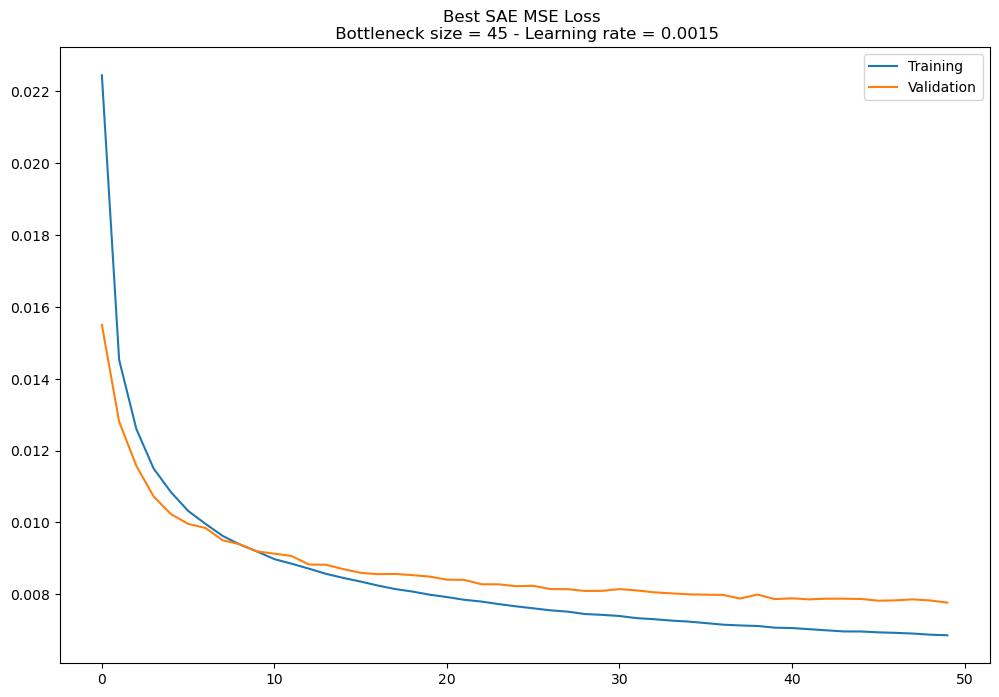

In [4]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

# best encoder
best_bottleneck_size = 45
best_lr = 0.0015
encoder = Encoder(best_bottleneck_size)
decoder = Decoder(best_bottleneck_size)
criterion = lambda pred, target: huber_loss(pred, target, delta=1.5)#nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=best_lr)

# Training
train_losse, val_losse = ae_training(
    encoder, decoder, train_loader, val_loader, device, epochs=50, optimizer=optimizer, criterion=criterion)

plt.figure(figsize=(12,8))
plt.title(f"Best SAE MSE Loss \n Bottleneck size = {best_bottleneck_size} - Learning rate = {best_lr}")
plt.plot(train_losse, label = 'Training')
plt.plot(val_losse, label = "Validation")
plt.legend()
plt.show()

# use SVM 

In [5]:

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:

# Extract bottleneck features
def extract_features(encoder, data_loader):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            encoded = encoder(images)
            features.append(encoded.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.vstack(features), np.hstack(labels)
    

In [32]:
# Extract features for train and test sets
X_train, y_train = extract_features(encoder, train_loader)
X_test, y_test = extract_features(encoder, test_loader)

# Train an SVM classifier
svm = SVC(kernel = 'rbf', C = 100)
svm.fit(X_train, y_train)

# Evaluate the classifier
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9318


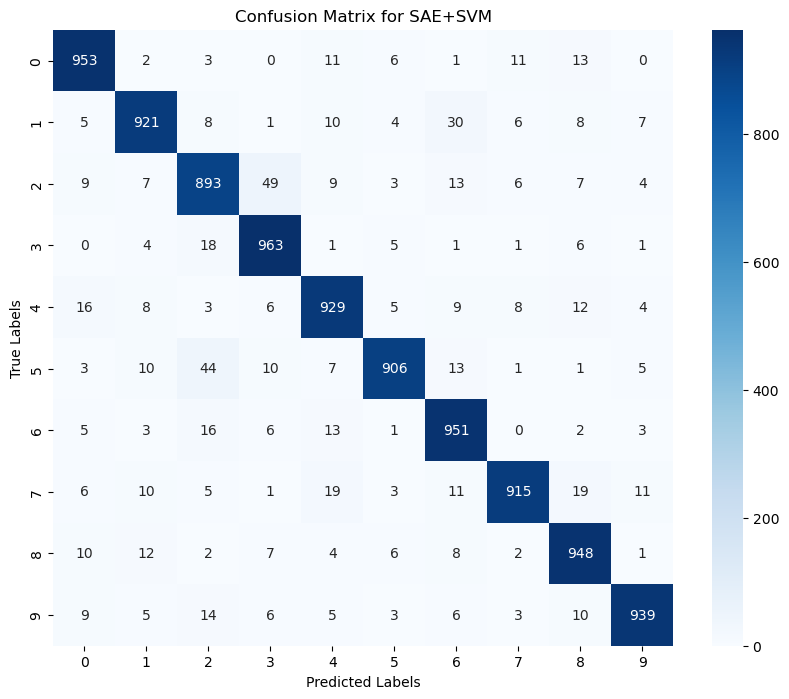

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SAE+SVM')
plt.show()

# generate noise images

In [38]:

# Freeze the encoder weights
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

max_res = 2
def generate_noisy_images(encoder, decoder, class_codes, device, num_images=1000, noise_std_range=(0., max_res)):
    
    decoder.eval()  # Ensure decoder is in evaluation mode
    generated_images = []
    labels = []

    images_per_class = num_images // len(class_codes)  # Equal distribution across classes

    for class_label, class_code in enumerate(class_codes):
        for _ in range(images_per_class):
            # Add zero-mean Gaussian noise to the class code
            noise_std = torch.FloatTensor(1).uniform_(*noise_std_range).item()  # Random variance
            noise = torch.randn_like(class_code) * noise_std
            noisy_code = class_code + noise

            # Reshape code to include batch dimension
            noisy_code = noisy_code.unsqueeze(0)  # Add batch dimension (1, bottleneck_size)

            # Reconstruct the image from the noisy code
            reconstructed_image = decoder(noisy_code.to(device)).cpu().detach()
            generated_images.append(reconstructed_image.squeeze(0))  # Remove batch dimension for storage
            labels.append(class_label)  # Correctly assign the class label

    # Stack images and labels into tensors
    generated_images = torch.stack(generated_images)
    labels = torch.tensor(labels, dtype=torch.long)

    return generated_images, labels


# Store one code per class
def store_class_codes(encoder, dataset_loader, device, num_classes):
    encoder.eval()  # Ensure encoder is in evaluation mode
    class_codes = [None] * num_classes  # Initialize a list with None for each class
    class_seen = [False] * num_classes

    with torch.no_grad():
        for images, labels in dataset_loader:
            images, labels = images.to(device), labels.to(device)
            bottleneck = encoder(images)
            
            for i, label in enumerate(labels):
                if not class_seen[label]:
                    class_codes[label] = bottleneck[i]  # Store bottleneck code at the correct class index
                    class_seen[label] = True
                    if all(class_seen):
                        return class_codes

    return class_codes


In [39]:
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(y_test)) 

# Store class codes
class_codes = store_class_codes(encoder, train_loader, device, num_classes)

# Freeze encoder
freeze_model(encoder)

# Geneerate images!
num_generated_images = 1000

generated_images, generated_labels = generate_noisy_images(
    encoder, decoder, class_codes, device, num_images=num_generated_images
)

# Preprocess generated images to match KMNIST format
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Apply preprocessing
processed_images = torch.stack([
    transform(Image.fromarray((img.view(28, 28).numpy() * 255).astype("uint8")))
    for img in generated_images])
generated_dataset = torch.utils.data.TensorDataset(processed_images, generated_labels)
generated_loader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

In [40]:
def plot_generated_images(images, labels, class_names, num_images=16):
    num_images = min(num_images, len(images))
    num_cols = int(num_images**0.5)
    num_rows = (num_images + num_cols - 1) // num_cols  # Ensure all images fit
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        image = images[i].squeeze(0).cpu().numpy()  # Convert to 2D array
        label = class_names[labels[i].item()]

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')

    # Hide any remaining axes if images < num_rows * num_cols
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


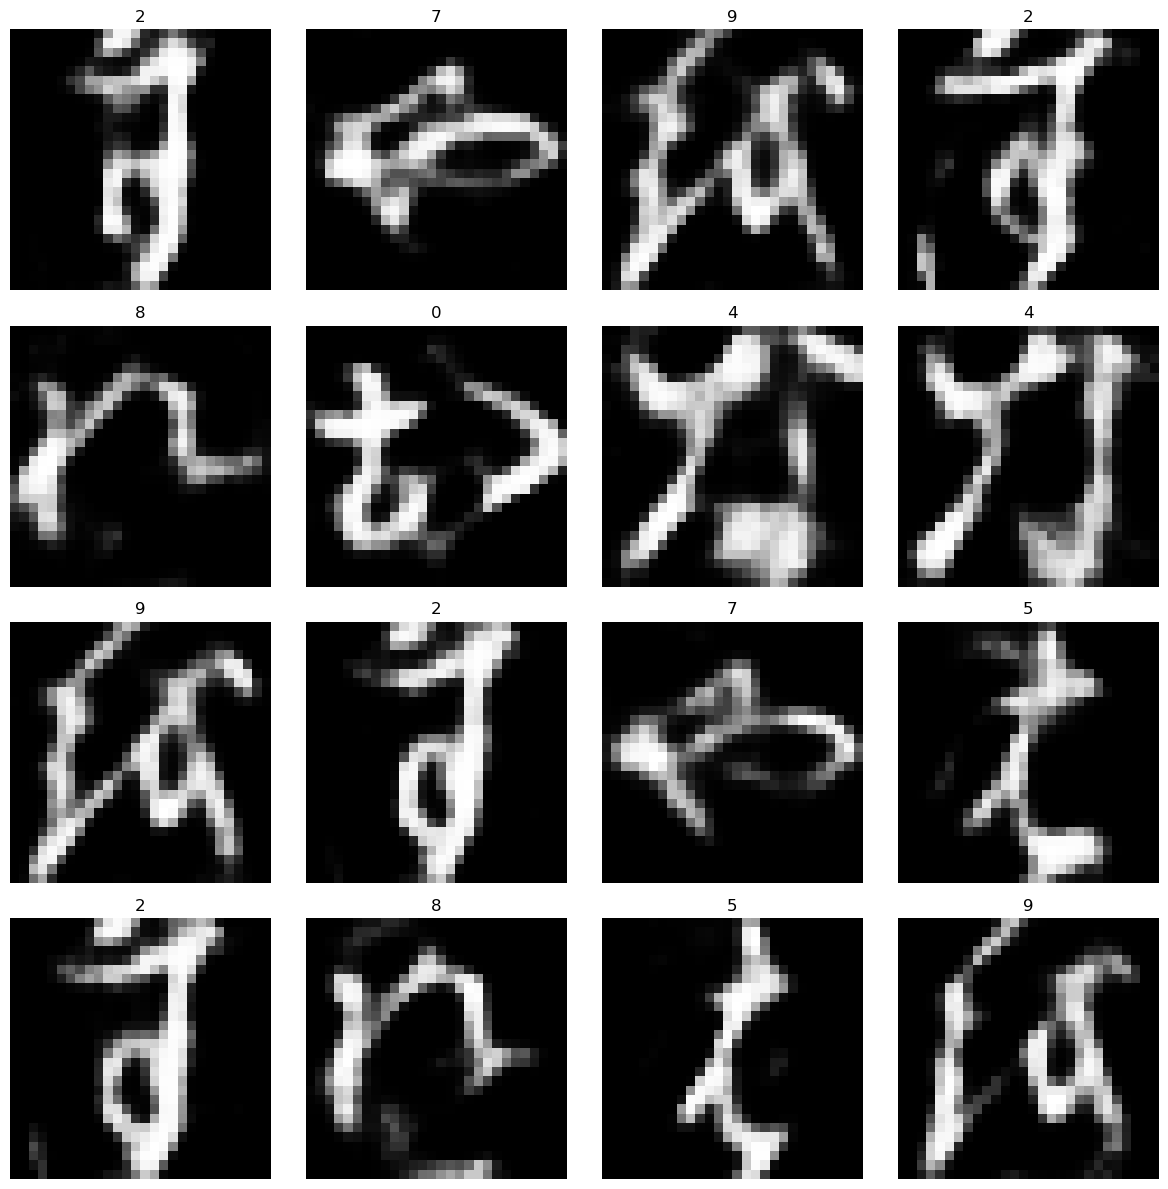

In [41]:
class_names = [str(i) for i in range(len(np.unique(y_test)))]  # Change this to actual class names if available
print(class_names)
generated_images_batch, generated_labels_batch = next(iter(generated_loader))  # Get a batch

plot_generated_images(
    images=generated_images_batch, 
    labels=generated_labels_batch, 
    class_names=class_names, 
    num_images=16
)

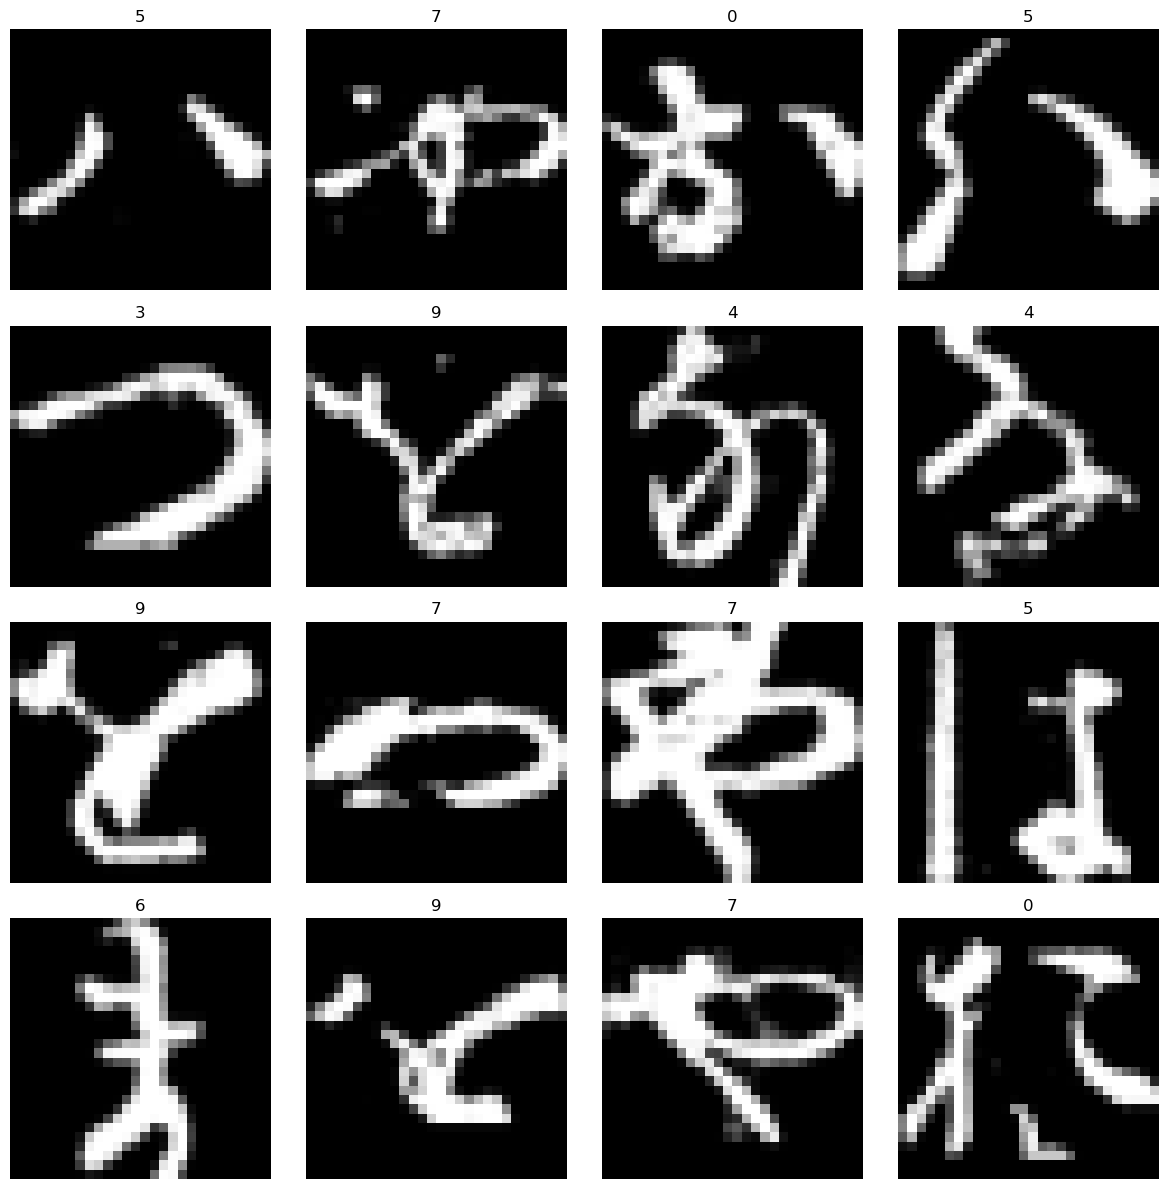

In [16]:
class_names = [str(i) for i in range(len(np.unique(y_test)))]  # Change this to actual class names if available
test_images_batch, test_labels_batch = next(iter(train_loader))  # Get a batch

plot_generated_images(
    images=test_images_batch, 
    labels=test_labels_batch, 
    class_names=class_names, 
    num_images=16
)

## use MLP from proj 1

In [17]:
class SuperLargeMLP(nn.Module):
    def __init__(self):
        super(SuperLargeMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        return self.model(x)

In [18]:

model_p1 = SuperLargeMLP()

weights_path = "./mn_super_large_loss_ce_lr_0.01_send.pth"
checkpoint = torch.load(weights_path, map_location=torch.device('cpu'))
state_dict = checkpoint["model_state_dict"]
model_p1.load_state_dict(state_dict)
model_p1.eval()

C:\Users\moaaz\AppData\Local\Temp\ipykernel_22268\1029881063.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=torch.dev

SuperLargeMLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=2048, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.4, inplace=False)
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.4, inplace=False)
    (17): Linear(in_features=512, out_features=256, bias=True)
    (18): Bat

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_p1.to(device)
# model_p1.to(device)

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in generated_loader:  
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_p1(inputs)
        # print((outputs))
        _, predicted = torch.max(outputs, 1) 
        predictions.extend(predicted.cpu().numpy()) 
        true_labels.extend(labels)
        # print(input)
        # print(f"label = {len(labels)} and predicted = {len(predicted)}")

In [43]:
accuracy_gen_2 = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy_gen_2:.4f}")

Test Accuracy: 0.9860


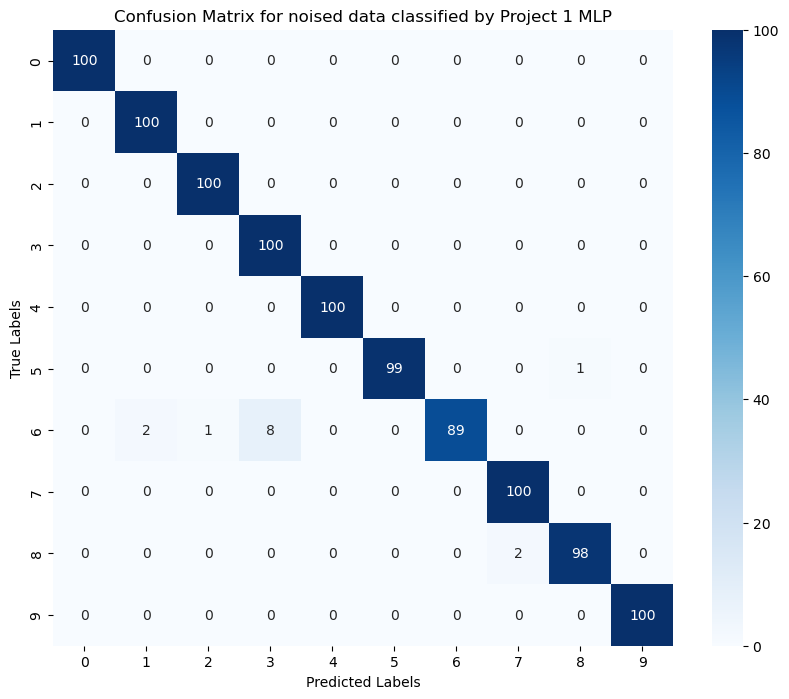

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for noised data classified by Project 1 MLP')
plt.show()

# use MLP instead of SVM

In [22]:
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [23]:
# def extract_features(encoder, data_loader, device):
#     encoder.eval()  # Set encoder to evaluation mode
#     features, labels = [], []

#     with torch.no_grad():
#         for data, label in data_loader:
#             data, label = data.to(device), label.to(device)  # Send data to device
#             encoded = encoder(data)  # Get the encoded features from the encoder
#             features.append(encoded.cpu().numpy())  # Convert to CPU for easier handling
#             labels.append(label.cpu().numpy())  # Convert labels to CPU as well

#     features = np.vstack(features)  # Stack all feature arrays
#     labels = np.concatenate(labels)  # Concatenate all label arrays
#     return features, labels

# Extract bottleneck features
def extract_features(encoder, data_loader):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            encoded = encoder(images)
            features.append(encoded.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.vstack(features), np.hstack(labels)

In [62]:



# Define the MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 265),
            nn.BatchNorm1d(265),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(265, num_classes)
        )

    def forward(self, x):
        x = self.mlp(x)
        x = nn.Softmax(dim=1)(x)  # Apply softmax on the output logits (along class dimension)
        return x
# Training function for MLP
def train_mlp(model, train_loader, val_loader, device, epochs, criterion, optimizer, patience=10):
    model.to(device)
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_epoch = 0
    best_weights = None
    epochs_without_improvement = 0  # Track how many epochs without improvement

    print("Starting MLP Training...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)

                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}, Val Accuracy: {val_accuracy:.4f}")

        # Check for improvement in validation loss
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_epoch = epoch
            best_weights = model.state_dict()  # Save the model's best weights
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1

        # Early stopping check based on patience
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} with validation loss: {val_losses[-1]:.6f}")
            break

    # Restore the best weights
    if best_weights is not None:
        model.load_state_dict(best_weights)
        print(f"Restored best weights from epoch {best_epoch+1}")

    return train_losses, val_losses

def evaluate_mlp(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            preds = outputs.argmax(dim=1)  # Get predicted class indices
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy


In [63]:
# Extract encoded features from your encoder
train_features, train_labels = extract_features(encoder, train_loader)
val_features, val_labels = extract_features(encoder, val_loader)

# Create PyTorch DataLoader for MLP
train_dataset_2 = torch.utils.data.TensorDataset(torch.tensor(train_features, dtype=torch.float32),
                                               torch.tensor(train_labels, dtype=torch.long))
val_dataset_2 = torch.utils.data.TensorDataset(torch.tensor(val_features, dtype=torch.float32),
                                             torch.tensor(val_labels, dtype=torch.long))

train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=64, shuffle=True)
val_loader_2 = torch.utils.data.DataLoader(val_dataset_2, batch_size=64, shuffle=False)

# Initialize MLP model, loss function, and optimizer
input_size = train_features.shape[1]  # Bottleneck size
num_classes = len(set(train_labels))  # Number of unique labels

mlp_model = MLPClassifier(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the MLP classifier
train_losses, val_losses = train_mlp(mlp_model, train_loader, val_loader, device, epochs=100, 
                                     criterion=criterion, optimizer=optimizer)


Starting MLP Training...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 45x2048)

In [ ]:
# Extract encoded features from your encoder for the test set
test_features, test_labels = extract_features(encoder, test_loader)

# Create DataLoader for test data
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_features, dtype=torch.float32),
                                              torch.tensor(test_labels, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the MLP classifier on the test set
test_accuracy = evaluate_mlp(mlp_model, test_loader, device)